<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT23/blob/juliusha/Lab3/report_lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 2: Approximations**
**Julius Häger**

# **Abstract**

TODO

#**About the code**

In [1]:
"""This program is lab report in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2023 Julius Häger (juliusha@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from IPython.display import display, Math

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common 
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *
    
#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

from scipy import integrate


# **Introduction**

In this Lab the goal is to create a piecewise linear function approximation using an $L_2$ projection. This projection can be stated as follows:
$$
P_Nf(x) = \sum_{j=1}^{N} α_j \phi_j(x)
$$
And where the values of $α$ can be found from the following equation:
$$
\sum_{j=1}^{N}α_j(\phi_j, \phi_i) = (f, \phi_i) \forall i = 1, \dots, N
$$

Which can be solved as a matrix equation $Aα = b$ where $A=(a_{ij})$ and $b=(b_i)$.
$$
a_{ij} = (\phi_j, \phi_i) = \int_{a}^{b} \phi_j(x) \phi_i(x) \, dx \\
b_i = (f, \phi_i) = \int_{a}^{b} f(x) \phi_i(x) \, dx
$$

# **Method**

## Assignment 1: $L_2$ projection to pw linear approximation over mesh in 1D



To implement L2 projection I used to formulation in Chapter 9 Part 5 in Methods in Computational Science. Because we are doing a piecewise linear approximation we know that the basis functions only have local support by the two neighbours, which makes the mass matrix tridiagonal and as such constructable in linear time. The load vector b is computed using scipy.integrate.quad to get a good value for the integral $\int_{0}^{1} f(x) \phi_k(x)\,dx$.

In [81]:
# Assignment 1: L2 projection to piece-wise linear approximation over mesh in 1D

from typing import Callable

# Input: function f(x), 1D mesh with nodes (x0,...,xn)
# Output: vector of L2 projection of f(x) evaluated in (x0,...,xn)
def λ(mesh : np.ndarray, k, i, x):
  if i == 0:
    return (mesh[k] - x) / (mesh[k] - mesh[k - 1])
  elif i == 1:
    return (x - mesh[k - 1]) / (mesh[k] - mesh[k - 1])
  else:
    raise Exception("i is out of bounds");

def hat(start, center, stop, x):
  if x > stop:
    return 0
  elif x > center:
    return (stop - x) / (stop - center)
  elif x >= start:
    return (x - start) / (center - start)
  else:
    return 0

def assemble_system(f : Callable[[np.double], np.double], mesh : np.ndarray):
  n = len(mesh);
  A = np.zeros((n, n))
  b = np.zeros(n)
  # we take care of the edges separately
  for k in range(1, n - 1):
    h_k = mesh[k] - mesh[k-1]
    h_k1 = mesh[k+1] - mesh[k]

    A[k, k] = h_k / 3 + h_k1 / 3
    A[k, k+1] = h_k1 / 6
    A[k, k-1] = h_k / 6

    b[k] = integrate.quad(lambda x : f(x) * hat(mesh[k-1], mesh[k], mesh[k+1], x), mesh[k-1], mesh[k+1])[0]

  A[0, 0] = (mesh[1] - mesh[0]) / 3
  A[0, 1] = (mesh[1] - mesh[0]) / 6
  A[-1, -1] = (mesh[-1] - mesh[-2]) / 3
  A[-1, -2] = (mesh[-1] - mesh[-2]) / 6

  b[0]  = integrate.quad(lambda x : f(x) * hat(mesh[ 0], mesh[ 0], mesh[ 1], x), mesh[ 0], mesh[ 1])[0]
  b[-1] = integrate.quad(lambda x : f(x) * hat(mesh[-2], mesh[-1], mesh[-1], x), mesh[-2], mesh[-1])[0]

  return A, b

def project_L2(f : Callable[[np.double], np.double], mesh : np.ndarray, x : np.ndarray):
  A, b = assemble_system(f, mesh)
  α = np.linalg.solve(A, b)
  y = np.interp(x, mesh, α)
  return y

# **Results**

## Assignment 1: $L_2$ projection to pw linear approximation over mesh in 1D

To verify that the approximation obtained is good we first compare the integral of the approximation to an analytically calculated integral of the original function.

Then we compare the original function $f$ to the approximation $Pf$ through the L2 norm as follows $|| f - Pf ||_{L2}$ to see how big the error is there.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

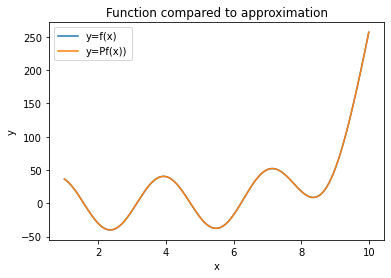

In [88]:
f = lambda x : np.sin(x*2)*40 + np.exp(x)*0.01

# Exact integral accuired from Wolfram Alpha:
# https://www.wolframalpha.com/input?i=integrate+sin%28x*2%29*40+%2B+exp%28x%29*0.01+dx
f_integral = lambda x : 0.01*np.exp(x) - 20*np.cos(2*x)

start = 1.0
stop = 10.0
no_eval_points = 1000
no_approx_points = 200
dist = stop - start

eval_points = np.linspace(start, stop, no_eval_points)

approx_points = np.linspace(start, stop, no_approx_points)

f_eval = f(eval_points)
f_approx = project_L2(f, approx_points, eval_points)

plt.title("Function compared to approximation")
plt.plot(eval_points, f_eval, label="y=f(x)")
plt.plot(eval_points, f_approx, label="y=Pf(x))")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

integral_exact = f_integral(stop) - f_integral(start)
integral_approx = np.trapz(f_approx, eval_points)

display(Math(rf"| \int_{{{start}}}^{{{stop}}} f(x) \,dx - \int_{{{start}}}^{{{stop}}} Pf(x) \,dx | = {np.abs(integral_approx - integral_exact)}"))
print()
display(Math(rf"|| f(x) - Pf(x) ||_{{L2}} = {np.linalg.norm(f_eval - f_approx)}"))

We can see that both metrics for the error of the approximation show that the approximation is quite accurate with 200 intervals which is a stepsize of $h = \frac{9}{200}$. We can also see in the plot the the approximated function quite accurately follow the original function.

To characterize how well this method works we will investigate the error in terms of the step size $e(h)$. To do this we will calculate the error for consecutive halvings of the step size to be able to approximate the rate of convergence.

<IPython.core.display.Math object>

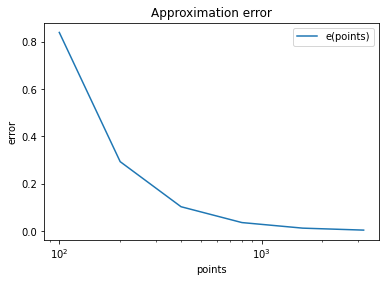

In [89]:
# convergence rate

points = np.array([100, 200, 400, 800, 1600, 3200])

values2 = [project_L2(f, np.linspace(start, stop, n), np.linspace(start, stop, n)) for n in points]
eval = [f(np.linspace(start, stop, n)) for n in points]

error = np.zeros(len(eval))
for i in range(len(eval)):
  error[i] = np.linalg.norm(values2[i] - eval[i])

plt.title("Approximation error")
plt.plot(points, error, label="e(points)")
plt.xscale("log")
plt.xlabel("points")
plt.ylabel("error")
plt.legend()

q = np.log(error[-1] / error[-2]) / np.log((dist / points[-1]) / (dist / points[-2]))
display(Math(rf"\text{{Error}} \approx O(h^{{{q}}})"))

As we can see the error decreases as we increase the number of intervals (i.e. reduce the step size).

# **Discussion**

This approximation relies on a good integral calculation which could be constly. Using some kind of higher order piecewise polynomial approximation could make reliance on a good integral function less necessary.